In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive, Interact
using AutoUrban
using VirtualTestDrive

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in @linux(::Any, ::Any) at ./deprecated.jl:484
 in include_from_node1(::String) at ./loading.jl:488 (repeats 2 times)
 in eval(::Module, ::Any) at ./boot.jl:234
 in require(::Symbol) at ./loading.jl:415
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/eric/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /home/eric/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading /home/eric/.julia/v0.5/VirtualTestDrive/src/system.jl, in expression starting on line 1


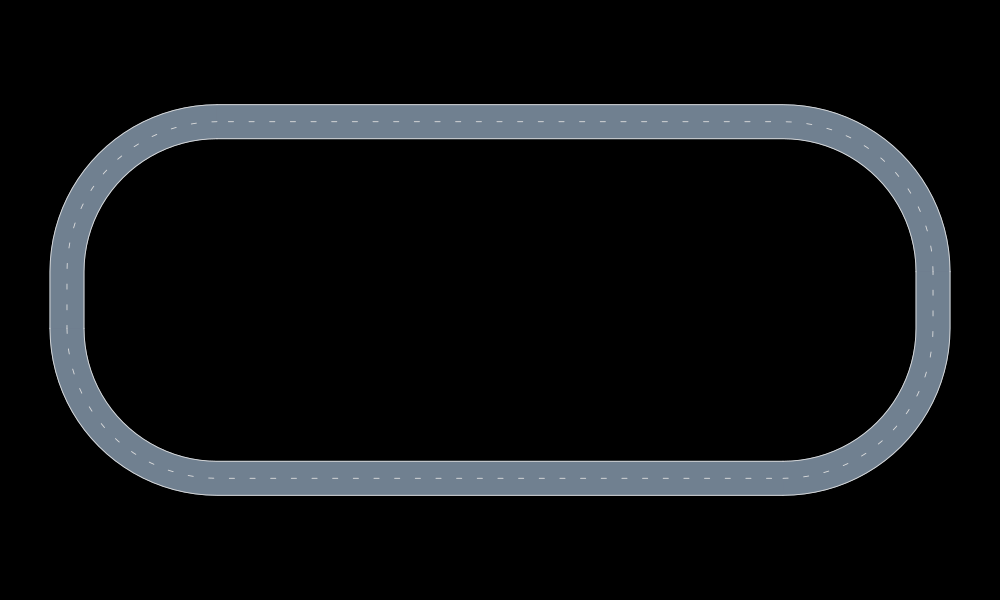

In [2]:
using Reactive, Interact
#Need a same roadway in VTD
scene = Frame(Entity{VehicleState, BicycleModel, Int},100)
timeStep = 0.05
models = Dict{Int, DriverModel}()
roadway = gen_stadium_roadway(2)

In [3]:
entries=VirtualTestDrive.processOneFrame();
for i in 1:length(entries[3])
    (x,y,heading,v)=(entries[3][i].base.pos.x,entries[3][i].base.pos.y,entries[3][i].base.pos.h,sqrt(entries[3][i].ext.speed.x^2+entries[3][i].ext.speed.y^2))
    push!(scene,Entity(VehicleState(VecSE2(x,y,heading), roadway, v), 
        BicycleModel(VehicleDef(AgentClass.CAR, 4.826, 1.81)),i))
    models[i]=MultiPtsTurningDriver(timeStep,v_max=5.0,v_min=0.0,turning_direction=1)
    excute_action!(models[i],0.0,0,scene, roadway, i)
end
actions = get_actions!(Array(Any, length(scene)), scene, roadway, models)
render(scene, roadway,cam=FitToContentCamera())

In [4]:
entries

16-element Array{Any,1}:
 RDB_START_OF_FRAME_t:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [5]:
function updateScene!(entries,scene)
    actions_VTD = []
    for i in 1:length(entries[3])
        veh = scene[i]
        (x,y,heading,v)=(entries[3][i].base.pos.x,entries[3][i].base.pos.y,entries[3][i].base.pos.h,sqrt(entries[3][i].ext.speed.x^2+entries[3][i].ext.speed.y^2))
        posG = VecSE2(x,y,heading)
        posF = Frenet(posG, roadway)
        state = VehicleState(posG,posF,v)
        scene[i] = Entity(state, veh.def, veh.id)
        steering=entries[4][i].steering
        acc=sqrt(entries[3][i].ext.accel.x^2+entries[3][i].ext.accel.y^2)
        if entries[3][i].ext.accel.x*cos(heading)+entries[3][i].ext.accel.y*sin(heading)<0
            acc=-acc
        end  
        push!(actions_VTD,AccelSteeringAngle(acc,steering))
    end
    tick!(scene,roadway,actions_VTD,timeStep)
end

updateScene! (generic function with 1 method)

In [6]:
function get_udp_entries(models)
    udp_entries = Array(VirtualTestDrive.RDB_PACKAGE_ELEMENT,0)
    for key = keys(models)
        udp_entry=VirtualTestDrive.create_udp_entry(VirtualTestDrive.RDB_DRIVER_CTRL_t,convert(UInt32,key),
            accelTgt=convert(Cfloat,models[key].siji.acc),steeringTgt=convert(Cfloat,models[key].siji.steer),
            validityFlags=convert(UInt32,VirtualTestDrive.RDB_DRIVER_INPUT_VALIDITY_TGT_ACCEL | VirtualTestDrive.RDB_DRIVER_INPUT_VALIDITY_TGT_STEERING | VirtualTestDrive.RDB_DRIVER_INPUT_VALIDITY_ADD_ON))
        push!(udp_entries,udp_entry)
    end
    #println(udp_entries)
    return udp_entries
end

get_udp_entries (generic function with 1 method)

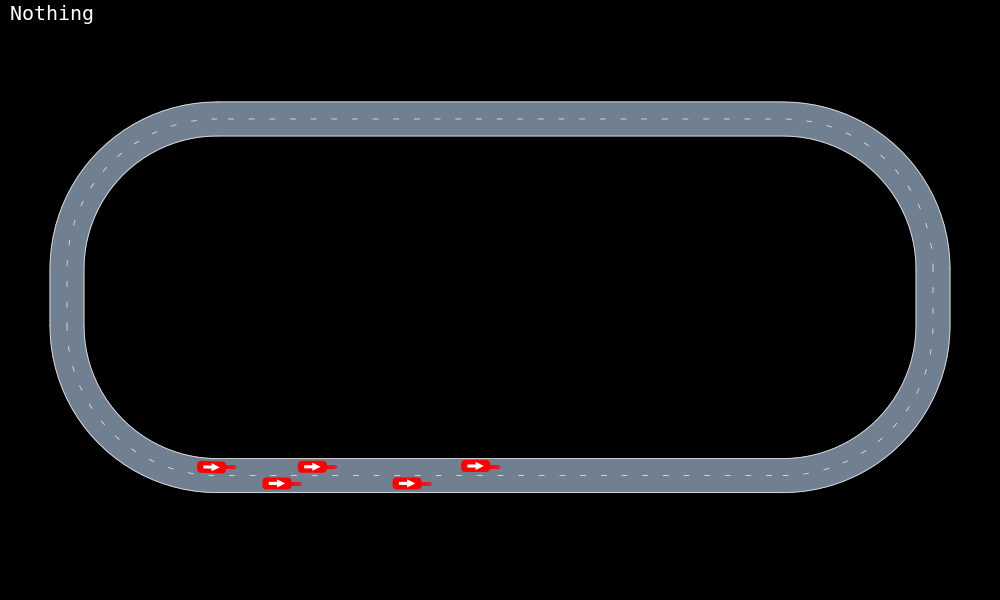

In [7]:
function drawsim(t)
    udp_entries = get_udp_entries(models)
    #print(udp_entries)
    entries=VirtualTestDrive.processOneFrame(udp_entries);
    updateScene!(entries,scene)
    for (i,veh) in enumerate(scene)
        if veh.state.v < 5.0
            excute_action!(models[i],2.0,0,scene, roadway, i)
            AutomotiveDrivingModels.observe!(models[veh.id], scene, roadway, veh.id)
        else
            excute_action!(models[i],0.0,0,scene, roadway, i)
            AutomotiveDrivingModels.observe!(models[veh.id], scene, roadway, veh.id)
        end
        AutomotiveDrivingModels.observe!(models[veh.id], scene, roadway, veh.id)
    end
    #render(scene, roadway,models,cam=SceneFollowCamera(10.0))
    render(scene, roadway, models, cam=FitToContentCamera())
end
framerate=24
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)